# Importing the Required Libraries

load all necessary libraries here

In [1]:
# common library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
%matplotlib notebook
import pickle
import functools
import operator

# NLP library
import nltk
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

# Importing the Dataset

we load data train set and test set from DATA folder and rename the columns name for easier processing at next step.
we also shuffle dataset so we can eliminate patterns/sequences in the label data and mainting random distribution.

In [2]:
# To import the dataset, we will use the Pandas read_csv function
train  = pd.read_csv('DATA/train_data_restaurant.tsv', sep='\t',header=None).sample(frac=1).reset_index(drop=True)
test = pd.read_csv('DATA/test_data_restaurant.tsv', sep='\t',header=None).sample(frac=1).reset_index(drop=True)
train.columns = ['sentence', 'label']
test.columns = ['sentence', 'label']
print("data training shape")
print(train.shape)
print("data testing shape")
print(test.shape)

data training shape
(1780, 2)
data testing shape
(185, 2)


Let's first see how the dataset looks like using the head() method:

In [3]:
train.head(19)

,sentence,label
0,Kombinasi yang sebenarnya agak aneh menurut sa...,positive
1,The Kiosk Braga salah satu alternatif tempat m...,negative
2,Salah satu restoran Sunda favorit saya di Band...,negative
3,disini selalu ramai dan antrian bisa panjang s...,negative
4,Suasananya bagus alami seperti di desa banget ...,negative
5,"Jajanan pasar, harga standar. rasa standar. ti...",negative
6,Saya melipir ke Ayam Goreng Raos karena terdes...,negative
7,Batagor terdiri dari siomay dan bakso tahu gor...,positive
8,"tempat unik, bagus buat foto"", makanan enak, p...",positive
9,ketika saya memilih untuk menginap di hotel di...,positive


# Check Null Values Present

In [4]:
print("is data training contain the null values")
print(train.isnull().sum())
print("is data testing contain the null values")
print(test.isnull().sum())

is data training contain the null values
sentence    0
label       0
dtype: int64
is data testing contain the null values
sentence    0
label       0
dtype: int64


# Change the Label

change the label of the dataset
    positive = 1,
    negative = 0

In [5]:
train["label"] = list(map(lambda x: 1 if x=="positive" else 0, train["label"]))
test["label"] = list(map(lambda x: 1 if x=="positive" else 0, test["label"]))

# Exploratory Data Analysis (EDA)

Let's explore the dataset a bit to see if we can find any trends. 

## Bar and Pie Plot for the Label in Dataset

we plot the label see the distribution and total of sentiments

<IPython.core.display.Javascript object>


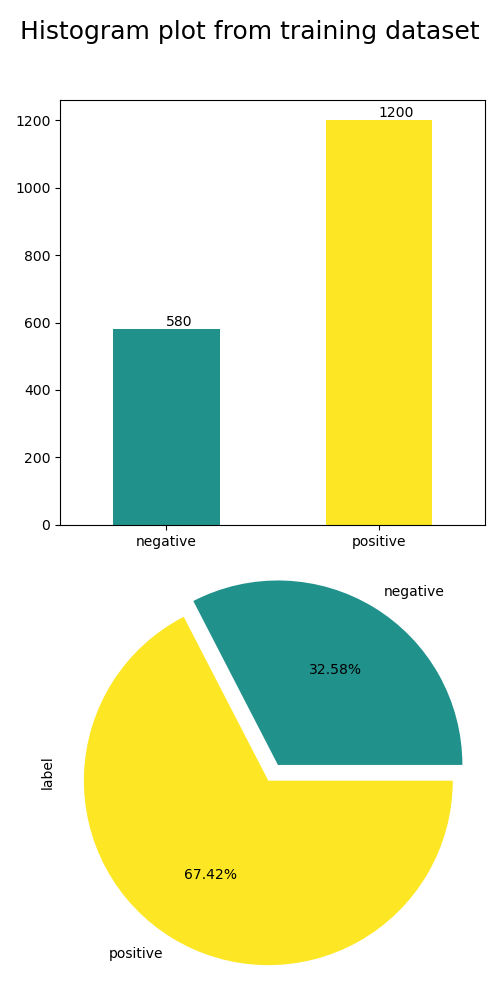

C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\imanursar\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
y_value = train["label"]
lab = "negative","positive"
yy = y_value.value_counts().sort_index()
labels = yy.axes[0].tolist()
x_value = np.arange(len(labels))
color = cm.viridis(np.linspace(0.5, 5, 5))
yy.sort_index().plot(kind='bar',stacked=True,color=color,ax=axes[0])
yy.plot.pie(autopct='%1.2f%%',ax=axes[1], explode=(0,0.1), labels=lab,colors=color)
for i in range(len(yy)):
    axes[0].text(i, yy[labels[i]]+10, str(yy[labels[i]]))

axes[0].set_xticklabels(["negative","positive"])
axes[0].xaxis.set_tick_params(rotation=0)
axes[1].axis('equal')
title = "Histogram plot from " + str("training") + " dataset"
fig.suptitle(title, size=18)
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

analysis:

* in the output, we can see the distribution of sentiment for each positive and negative reviews. with 67.42% as positive reviews and 32.58% as negative reviews.
* we have imbalanced dataset with different around 620 more for positive review.

# WordCloud

make a word cloud to see what kind of words most appear in data training

<IPython.core.display.Javascript object>


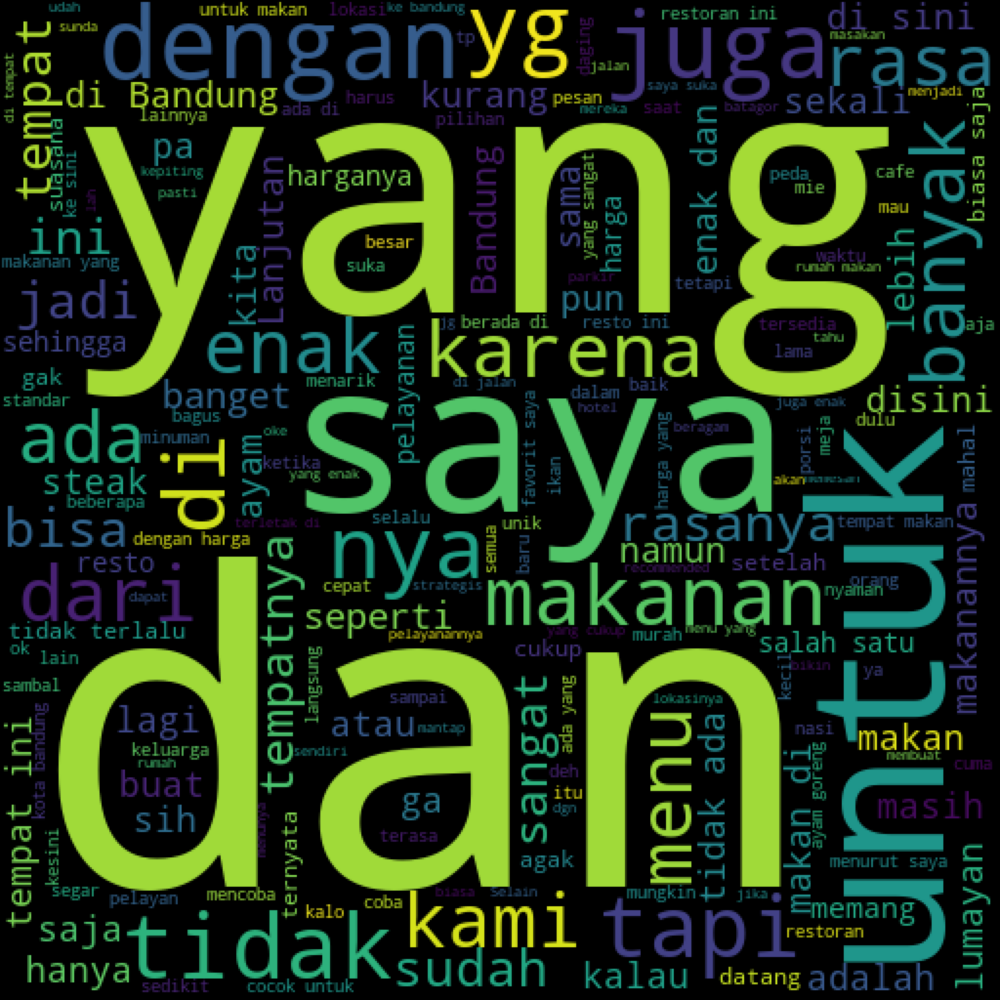

In [8]:
review_words = ' '.join(list(train["sentence"]))
res = WordCloud(width = 512,height = 512).generate(review_words)
plt.figure(figsize = (10, 10), facecolor = 'k')
plt.imshow(res)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

* as you can see at figure above, the dataset contain so much stopword (i.e. yang, tidak, untuk, dan, dengan etc.). 

* the other word like "enak", "lumayan" and with small amount for "strategis" and "suka" that maybe contain a positive review.

* in the other hand, the words like "tidak", "kurang" that lead to a negative review.

# Text Preprocessing

the dataset contain many slang words and punctiation masks. We need to clean the dataset before they can be used for training the machine learning model.
we can preprocess data in order to clean it using regular expressions. 

In [6]:
# load stopwords for bahasa in NLTK
nltk.download('stopwords')
id_stop = set(nltk.corpus.stopwords.words('indonesian'))

# load stemming modul from Sastrawi
factory_Stemmer = StemmerFactory()
stemmer = factory_Stemmer.create_stemmer()

def preprocess_text(sentence):
    # Remove all the special characters
    # remove all the non-word characters (letters and numbers) from a string and keep the remaining characters
    sentence = re.sub(r'\W', ' ', str(sentence))

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    # Sometimes removing punctuation marks, such as an apostrophe, results in a single character which has no meaning
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remove single characters from the start
    sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', sentence)
    
    # Remove enter type to space
    sentence = sentence.replace("\n"," ")
    
    # Substituting multiple spaces with single space
    sentence = re.sub(r'\s+', ' ', sentence)
    
    #removes spaces from the start and end 
    sentence = re.sub(r"\s+$", "", sentence)
    sentence = re.sub(r"^\s+", "", sentence)
    
    # Converting to Lowercase
    sentence = sentence.lower()
    
    # split our list for NLTK
    sentence = sentence.split()
    
    # stop word from NLTK
    sentence = [word for word in sentence if word not in id_stop]
    
    # words with length less than 4, such as "era", have also been removed.
    sentence = [word for word in sentence if len(word) > 3]
    
    # combine our sentence for Sastrawi
    sentence = ' '.join(sentence)
    
    # Steeeming = reduce the word into dictionary root form
    # Stemming with Python Sastrawi
    sentence = stemmer.stem(sentence)
    
    return sentence

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


the Text Preprocessing function clean the dataset with this step:

* Remove all the special characters (remove all the non-word characters (letters and numbers) from a string and keep the remaining characters)
* Remove punctuations and numbers
* Single character removal (Sometimes removing punctuation marks, such as an apostrophe, results in a single character which has no meaning)
* Remove single characters from the start
* Remove enter type to space
* Substituting multiple spaces with single space
* removes spaces from at the end 
* Converting sentence to Lowercase
* stop word from NLTK (you can see the difference stop word from NLTK with Sastrawi at comparing_the_stop_word_from_NLTK_with_Sastrawi_library.ipynb)
* words with length less than 3, such as "era", have also been removed.
* Stemming with Sastrawi Library (Steeeming = reduce the word into dictionary root form)

## Apply preprocess_text Function to the Dataset

In [10]:
# apply preprocess_text function to out training dataset
reviews = []
sentences = list(train["sentence"])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [7]:
# apply preprocess_text function to out testing dataset
reviews_test = []
sentences = list(test["sentence"])
for sen in sentences:
    reviews_test.append(preprocess_text(sen))

## Save and Load the Dataset After Text Preprocessing

because the Stemming process sometimes takes a long time, I have prepared the results of the text preprocessing into a pickel file that can be saved and loaded in the section below:

### save dataset

In [12]:
# save train dataset
with open('DATA/clean_text_train', 'wb') as picklefile:
    pickle.dump(reviews,picklefile)

In [8]:
# save test dataset
with open('DATA/clean_text_test', 'wb') as picklefile:
    pickle.dump(reviews_test,picklefile)

In [14]:
# save label train dataset
with open('DATA/label_train', 'wb') as picklefile:
    pickle.dump(train["label"],picklefile)

In [9]:
# save label test dataset
with open('DATA/label_test', 'wb') as picklefile:
    pickle.dump(test["label"],picklefile)

### load dataset

In [16]:
# load pickel file here
with open('DATA/clean_text_train', 'rb') as picklefile:
    reviews = pickle.load(picklefile)

# Text Exploration

we can explore more about the dataset after the cleaning process to see the difference between positive review and the negative review

In [17]:
review_positive = []
review_negative = [] 
for i in range(len(reviews)):
    if (train.loc[i]["label"] == 1):
        review_positive.append(reviews[i])
    else:
        review_negative.append(reviews[i])

## WordCloud

make a word cloud to see what kind of words most appear in positive review and  negative review

<IPython.core.display.Javascript object>


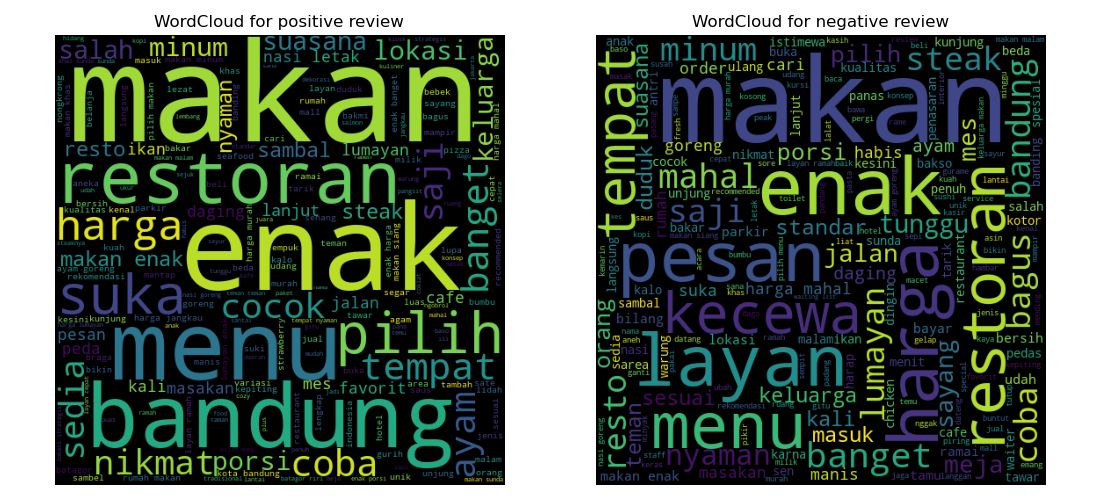

In [18]:
review_pos_words = ' '.join(list(review_positive))
res_pos = WordCloud(width = 512,height = 512).generate(review_pos_words)
review_neg_words = ' '.join(list(review_negative))
res_neg = WordCloud(width = 512,height = 512).generate(review_neg_words)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
ax[0].imshow(res_pos)
ax[1].imshow(res_neg)
ax[0].set_facecolor('k')
ax[1].set_facecolor('k')
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('WordCloud for positive review')
ax[1].set_title('WordCloud for negative review')
plt.tight_layout()
plt.show()

there is interesting discovery with this saparate wordcloud, as you can see at positive review, we can see some positive word like "enak", "suka", "nikmat" (and several neutral word like "bandung", "menu" "restoran"). 

but when we see at negative review, we also find similiar word with positive review such as "enak". this word may be from negative word like "tidak enak", or a review that contain "enak" word but label as negative review as a whole sentence.

In [19]:
for t in review_negative[:20]:
    if 'enak' in t:
        print (t)
        print("\n")

udah banget ken kesini pasang temen temen ramean denger denger cerita temen cozy enak dijadiin nongkrong anak muda dapet kerja langsung kesini bareng pacar sen cappucino lemon loyang meat lovers pizza them recommended even delicious


kangkung hotplate udang kipas enak fuyunghai patut coba sayang restoran kotor lihat kecoa piring sayur bersih pakai saji makan kecoa duduk harap bersih baik lidah orang bandung


heran orang bilang enak makan harga sesuai


denger lawang wangi makan enak mkanannya enak recommended banget layan ramah lawang wangi bagus tempat


enak resto korea authentic tempat bagus dekor comfortable


well kali kerja family trip friends couple dar santai tempat enak alun musik sunda relaxing gubuk makan nikmatin suasa alam tata natural sayang makan enak standart coba harap makan


suka bubur enak porsi kepiting soka lada garam enak minyak kecewa nikmat kepiting




as we can see at above section, we can see sentences that contain "enak" word in negative review. if we read whole sentence we can agree with the negative label that given to that sentence.

## The Most Common Word

The words are plotted again to find the most frequently used terms. A few simple words repeat more often than others: ’makan’, ‘enak’, ‘harga’, ’menu’, etc. these words are words that generally appear frequently in restaurant reviews.

In [20]:
tokens = [nltk.tokenize.word_tokenize(i) for i in review_positive]
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])
common = functools_reduce_iconcat(tokens)
fdist_positive=nltk.FreqDist(common)
most = fdist_positive.most_common(10)
least_positive = dict(fdist_positive.most_common()[-50:])

In [21]:
tokens = [nltk.tokenize.word_tokenize(i) for i in review_negative]
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])
common = functools_reduce_iconcat(tokens)
fdist_negative=nltk.FreqDist(common)
most = fdist_negative.most_common(10)
least_negative = dict(fdist_negative.most_common()[-50:])

<IPython.core.display.Javascript object>


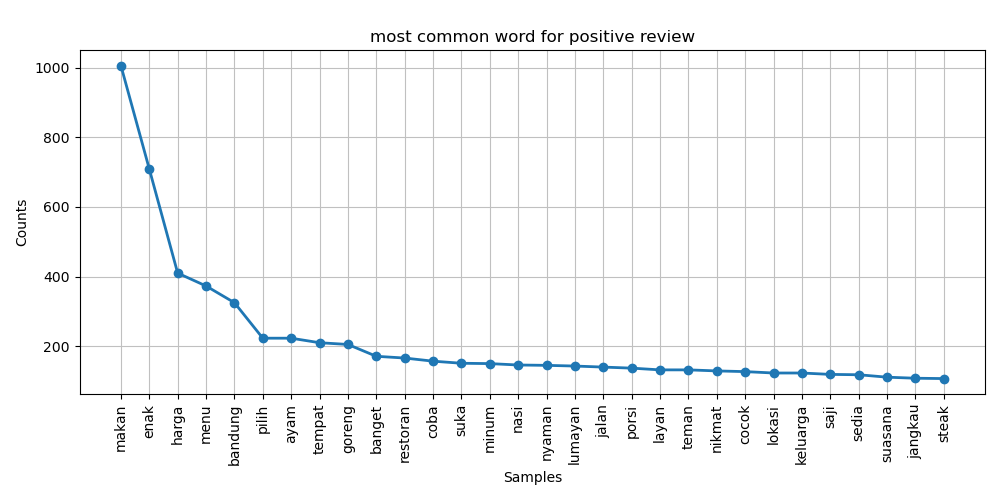

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
fdist_positive.plot(30,cumulative=False,marker="o", linestyle="-")
ax.set_title('most common word for positive review')
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

<IPython.core.display.Javascript object>


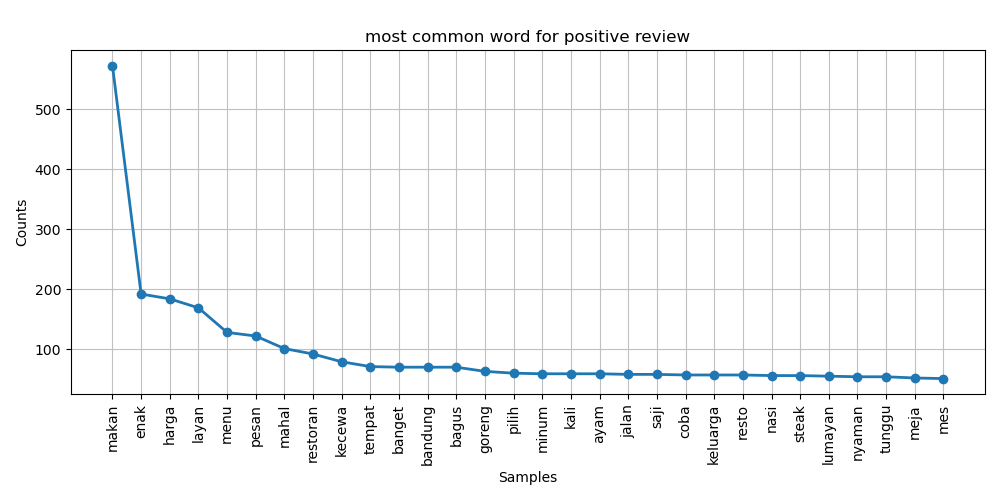

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
fdist_negative.plot(30,cumulative=False,marker="o", linestyle="-")
ax.set_title('most common word for positive review')
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

## Less Common Word

In [23]:
pd.DataFrame(least_positive.items(), columns=["positive_review","value"])

,positive_review,value
0,tedapat,1
1,transaksi,1
2,tolak,1
3,offline,1
4,always,1
5,miss,1
6,dur,1
7,slalu,1
8,tras,1
9,balitanya,1


In [24]:
pd.DataFrame(least_negative.items(), columns=["negative_review","value"])

,negative_review,value
0,driver,1
1,kapokkkk,1
2,tanah,1
3,qualitas,1
4,amerika,1
5,bantat,1
6,cokelat,1
7,toko,1
8,amanda,1
9,kreasi,1
